## Accessing Sentinel-3 SRAL data with the Planetary Computer STAC API

The [Sentinel 3 SRAL instrument](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-altimetry) uses Synthetic Aperture Radar (SAR) to measure surface height, significant wave height, and wind speed over the ocean surface.
There are two SRAL collections in the Plantery Computer:

- Land measurements: `sentinel-3-sral-lan-l2-netcdf`
- Water measurements: `sentinel-3-slstr-wat-l2-netcdf`

This notebook demonstrates accessing and visualizing data from both collections.

### Data Access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. If you are using the [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) to run this notebook, then your API key is automatically set to the environment variable `PC_SDK_SUBSCRIPTION_KEY` for you when your server is started. Otherwise, you can view your keys by signing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be manually set via the environment variable `PC_SDK_SUBSCRIPTION_KEY` or the following code:

```python
import planetary_computer
planetary_computer.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available in [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.



### Water measurements

The collection's description provides more information about the water product.

In [1]:
import planetary_computer
import pystac_client
from IPython.display import display, Markdown

catalog = pystac_client.Client.open(
    "http://planetarycomputer-staging.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
collection = catalog.get_collection("sentinel-3-sral-wat-l2-netcdf")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-sral-wat-l2-netcdf

This Collection provides Sentinel-3 [SRAL Level-2 Ocean Altimetry](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-altimetry/level-2-algorithms-products) products, which contain data on ocean radar altimetry measurements. Each product contains three NetCDF files:

- A reduced data file containing a subset of the 1 Hz Ku-band parameters.
- A standard data file containing the standard 1 Hz and 20 Hz Ku- and C-band parameters.
- An enhanced data file containing the standard 1 Hz and 20 Hz Ku- and C-band parameters along with the waveforms and parameters necessary to reprocess the data.

More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-altimetry/overview) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-altimetry).

This Collection contains Level-2 data in NetCDF files from January 2017 to present.


### Define the area of interest and search the water collection

We'll search for items.
Since this is an altimetry product, the swaths of data are very narrow, making a point-based search unrealistic.
We search for any product that intersects the Gulf of Mexico.

In [2]:
import xarray as xr
import fsspec

geometry = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.8376336, 28.3457752],
            [-92.3259525, 29.3100131],
            [-89.5198038, 28.8301497],
            [-87.049173, 30.183914],
            [-83.1468269, 28.6421247],
            [-81.6808886, 23.9413637],
            [-85.0055647, 22.0886049],
            [-90.4653539, 21.4938454],
            [-90.8618749, 19.4939949],
            [-92.9054832, 18.7158187],
            [-96.1081528, 19.1774025],
            [-97.6942368, 23.4665839],
            [-95.8376336, 28.3457752],
        ]
    ],
}
search = catalog.search(
    collections=["sentinel-3-sral-wat-l2-netcdf"], intersects=geometry
)
item = next(search.items())

### Available Assets and Metadata

Each item includes a handful of assets linking to NetCDF files with the data or additional metadata files.

In [3]:
import rich.table

t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                  ┃ Value                                                                                    ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ eop-metadata         │ Product metadata file produced by the European Organisation for the Exploitation of      │
│                      │ Meteorological Satellites (EUMETSAT)                                                     │
│ safe-manifest        │ SAFE product manifest                                                                    │
│ reduced-measurement  │ Reduced measurement data file                                                            │
│ enhanced-measurement │ Enhanced measurement data file                                                           │
│ standard-measurement │ Standard measurement data file                                                           │
└──────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

### Reading data

We can use xarray to read each NetCDF file directly from Blob Storage.

In [4]:
dataset = xr.open_dataset(fsspec.open(item.assets["standard-measurement"].href).open())
dataset

<xarray.Dataset>
Dimensions:                                        (time_01: 1687,
                                                    time_20_ku: 33611,
                                                    time_20_c: 32900)
Coordinates:
  * time_01                                        (time_01) datetime64[ns] 2...
  * time_20_ku                                     (time_20_ku) datetime64[ns] ...
  * time_20_c                                      (time_20_c) datetime64[ns] ...
    lat_01                                         (time_01) float64 ...
    lon_01                                         (time_01) float64 ...
    lat_20_ku                                      (time_20_ku) float64 ...
    lon_20_ku                                      (time_20_ku) float64 ...
    lat_20_c                                       (time_20_c) float64 ...
    lon_20_c                                       (time_20_c) float64 ...
Data variables: (12/294)
    UTC_day_01                                     (time_01) datetime64[ns] ...
    UTC_sec_01                                     (time_01) float64 ...
    UTC_day_20_ku                                  (time_20_ku) datetime64[ns] ...
    UTC_sec_20_ku                                  (time_20_ku) float64 ...
    UTC_day_20_c                                   (time_20_c) datetime64[ns] ...
    UTC_sec_20_c                                   (time_20_c) float64 ...
    ...                                             ...
    num_20hz_meas_01_ku                            (time_01) float32 ...
    num_20hz_meas_01_c                             (time_01) float32 ...
    orbit_type_01                                  (time_01) float32 ...
    waveform_qual_ice_20_ku                        (time_20_ku) float32 ...
    iono_cor_alt_filtered_01_ku                    (time_01) float32 ...
    iono_cor_alt_filtered_01_plrm_ku               (time_01) float32 ...
Attributes: (12/62)
    Conventions:                                 CF-1.6
    title:                                       IPF SRAL/MWR Level 2 Measure...
    mission_name:                                Sentinel 3A
    altimeter_sensor_name:                       SRAL
    radiometer_sensor_name:                      MWR
    gnss_sensor_name:                            GNSS
    ...                                          ...
    algo_bias_wind_speed_sig0_sar_ku_added:      -0.0413
    algo_bias_wind_speed_2p_sig0_sar_ku_added:   2.744
    algo_bias_wind_speed_2p_swh_sar_ku_added:    0.0
    algo_bias_wind_speed_sig0_plrm_ku_added:     -0.0382
    algo_bias_wind_speed_2p_sig0_plrm_ku_added:  2.7525
    algo_bias_wind_speed_2p_swh_plrm_ku_added:   0.0

### Visualizing

There's a huge numbers of variables here, and going into detail on them is beyond the scope of this example.
To demonstrate data access and visualization, we'll plot a significant wave height value, `swh_ocean_01_ku`.
This is 1HZ data from the KU band of the altimeter.
Significant wave height is ["an average measurement of the largest 33% of waves."](https://www.weather.gov/mfl/waves)

In [5]:
import pandas

data = pandas.DataFrame(
    {
        # Longitude values are between zero and 360, so we remap them to -180 to 180.
        "longitude": (dataset.lon_01.data.ravel() + 180) % 360 - 180,
        "latitude": dataset.lat_01.data.ravel(),
        "swh": dataset.swh_ocean_01_ku.load().data.ravel(),
    }
).dropna()
data

,longitude,latitude,swh
155,-49.801750,-69.674871,0.113000
156,-49.878709,-69.621577,0.530000
157,-49.955304,-69.568252,0.889000
164,-50.481525,-69.194144,0.461000
165,-50.555308,-69.140583,0.266000
...,...,...,...
1432,-113.045607,72.682893,13.717001
1436,-113.465927,72.887501,0.859000
1506,-122.663840,76.302961,-0.199000
1507,-122.826110,76.348886,0.178000


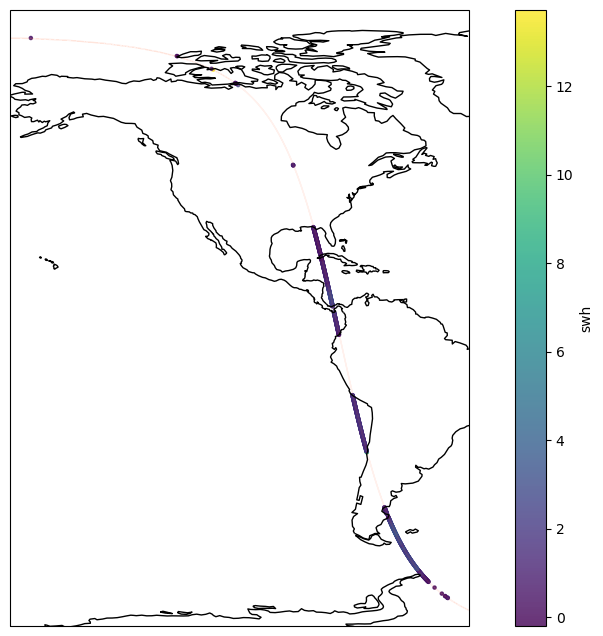

In [11]:
import shapely.geometry
from cartopy.crs import PlateCarree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    subplot_kw=dict(projection=PlateCarree()),
    figsize=(12, 8),
)

ax.add_geometries(
    shapely.geometry.shape(item.geometry),
    crs=PlateCarree(),
    color="coral",
    alpha=0.1,
)

data.plot.scatter(
    x="longitude",
    y="latitude",
    c="swh",
    ax=ax,
    colormap="viridis",
    marker=".",
    alpha=0.8,
)
ax.coastlines();

Not very interesting.
Let's try the mean sea surface height stored in `mean_sea_surf_sol1_01`.

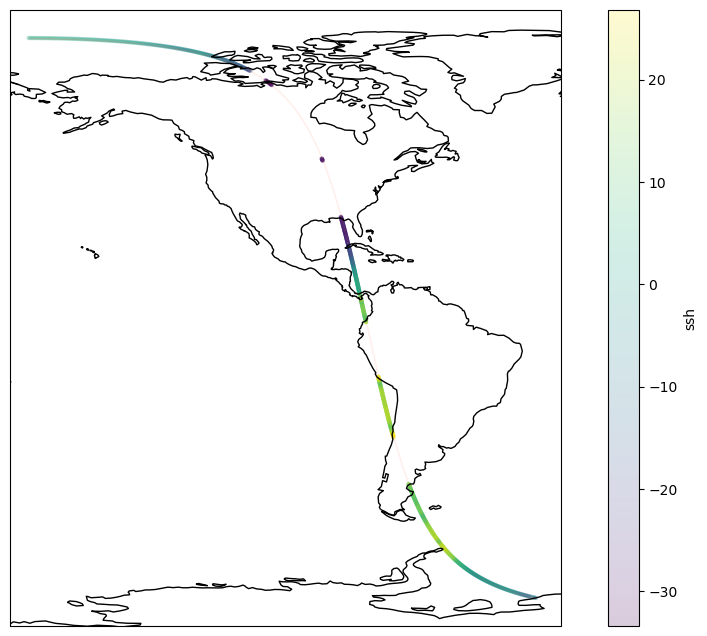

In [13]:
data = pandas.DataFrame(
    {
        # Longitude values are between zero and 360, so we remap them to -180 to 180.
        "longitude": (dataset.lon_01.data.ravel() + 180) % 360 - 180,
        "latitude": dataset.lat_01.data.ravel(),
        "ssh": dataset.mean_sea_surf_sol1_01.load().data.ravel(),
    }
).dropna()
fig, ax = plt.subplots(
    subplot_kw=dict(projection=PlateCarree()),
    figsize=(12, 8),
)

ax.add_geometries(
    shapely.geometry.shape(item.geometry),
    crs=PlateCarree(),
    color="coral",
    alpha=0.1,
)

data.plot.scatter(
    x="longitude",
    y="latitude",
    c="ssh",
    ax=ax,
    colormap="viridis",
    marker=".",
    alpha=0.2,
)
ax.coastlines();

### Land data

Let's do the same process, but for the land product, which is very similar to the water product but just processed by a different centre.
We'll use the reduced NetCDF this time, which has the most useful subset of variables.
We'll plot `mean_dyn_topo_01`, which is the mean dynamic topography.

In [14]:
collection = catalog.get_collection("sentinel-3-sral-lan-l2-netcdf")

display(Markdown(f"### {collection.id}\n\n{collection.description}"))

### sentinel-3-sral-lan-l2-netcdf

This Collection provides Sentinel-3 [SRAL Level-2 Land Altimetry](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-altimetry/level-2-algorithms-products) products, which contain data on land radar altimetry measurements. Each product contains three NetCDF files:

- A reduced data file containing a subset of the 1 Hz Ku-band parameters.
- A standard data file containing the standard 1 Hz and 20 Hz Ku- and C-band parameters.
- An enhanced data file containing the standard 1 Hz and 20 Hz Ku- and C-band parameters along with the waveforms and parameters necessary to reprocess the data.

More information about the product and data processing can be found in the [User Guide](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-3-altimetry/overview) and [Technical Guide](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-3-altimetry).

This Collection contains Level-2 data in NetCDF files from March 2016 to present.


In [15]:
search = catalog.search(
    collections=["sentinel-3-sral-lan-l2-netcdf"],
    intersects=geometry,
)
item = next(search.items())
t = rich.table.Table("Key", "Value")
for key, asset in item.assets.items():
    t.add_row(key, asset.description)

t

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                  ┃ Value                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ safe-manifest        │ SAFE product manifest          │
│ reduced-measurement  │ Reduced measurement data file  │
│ enhanced-measurement │ Enhanced measurement data file │
│ standard-measurement │ Standard measurement data file │
└──────────────────────┴────────────────────────────────┘

In [16]:
dataset = xr.open_dataset(fsspec.open(item.assets["reduced-measurement"].href).open())
dataset

<xarray.Dataset>
Dimensions:                             (time_01: 1548)
Coordinates:
  * time_01                             (time_01) datetime64[ns] 2023-04-07T1...
    lat_01                              (time_01) float64 ...
    lon_01                              (time_01) float64 ...
Data variables: (12/47)
    UTC_day_01                          (time_01) datetime64[ns] ...
    UTC_sec_01                          (time_01) float64 ...
    surf_type_01                        (time_01) float32 ...
    surf_class_01                       (time_01) float32 ...
    rad_surf_type_01                    (time_01) float32 ...
    alt_01                              (time_01) float64 ...
    ...                                  ...
    rain_flag_01_plrm_ku                (time_01) float32 ...
    open_sea_ice_flag_01_ku             (time_01) float32 ...
    open_sea_ice_flag_01_plrm_ku        (time_01) float32 ...
    orbit_type_01                       (time_01) float32 ...
    iono_cor_alt_filtered_01_ku         (time_01) float32 ...
    iono_cor_alt_filtered_01_plrm_ku    (time_01) float32 ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    title:                             IPF SRAL/MWR Level 2 Measurement
    mission_name:                      Sentinel 3B
    altimeter_sensor_name:             SRAL
    radiometer_sensor_name:            MWR
    gnss_sensor_name:                  GNSS
    ...                                ...
    xref_iono_data:                    S3B_SR_2_RGI_AX_20230407T000000_202304...
    xref_mog2d_data:                   S3__SR_2_RMO_AX_20230407T120000_202304...
    xref_seaice_concentration:         S3__SR_2_SIC_AX_20230405T000000_202304...
    xref_altimeter_ltm:                S3B_SR_1_CA1LAX_20000101T000000_202305...
    xref_doris_uso:                    S3B_SR_1_USO_AX_20180501T144459_202304...
    xref_time_correlation:             S3B_AX___FRO_AX_20230407T000000_202304...

In [17]:
import pandas

data = pandas.DataFrame(
    {
        "longitude": dataset.lon_01.data.ravel(),
        "latitude": dataset.lat_01.data.ravel(),
        "topography": dataset.mean_dyn_topo_01.load().data.ravel(),
    }
).dropna()
data

,longitude,latitude,topography
0,359.155705,81.413514,-0.3510
1,358.755180,81.412293,-0.3493
2,358.354786,81.410668,-0.3371
3,357.954560,81.408639,-0.3336
4,357.554537,81.406205,-0.3287
...,...,...,...
1330,225.251033,-74.585162,-1.1825
1331,225.121916,-74.633909,-1.1828
1332,224.992024,-74.682586,-1.1833
1333,224.729891,-74.779726,-1.1839


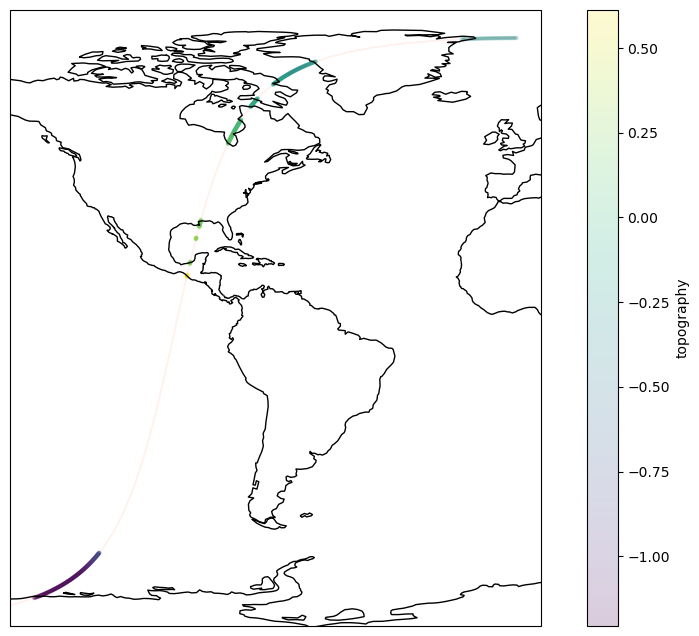

In [21]:
fig, ax = plt.subplots(
    subplot_kw=dict(projection=PlateCarree()),
    figsize=(12, 8),
)

ax.add_geometries(
    shapely.geometry.shape(item.geometry),
    crs=PlateCarree(),
    color="coral",
    alpha=0.1,
)

data.plot.scatter(
    x="longitude",
    y="latitude",
    c="topography",
    ax=ax,
    colormap="viridis",
    marker=".",
    alpha=0.2,
)
ax.coastlines();